# PA001: Airbnb

# Planejamento da solução (IOT)

# Input - Entrada 
   

## O problema de negócio

 1. Mapear as previsões de escolha de destino aos usuários de uma plataforma de locação de hospedagem.

# Output - Saída

## Modelo de Previsão para escolha do primeiro destino do usuário.


   1.0. Predições serão salvas em uma tabela do banco de dados.

   2.0. API

   Input: usuários e suas características;

   Output: usuários e suas características com a predição do destino;

# Tasks - Processo

 * New York City Airbnb Open Data:
 * https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data/code
 * Airbnb listings and metrics in NYC, NY, USA (2019)
    

*- Compreensão do modelo de negócio do Airbnb*
   - Marketplace ( Conectar pessoas que oferecem acomodação, com pessoas que estão procurando acomodação).
 
    
*- Usuários oferecem acomodações*
   - Tamanho do portfólio.
   - Diversidade/Densidade de Portfólio.
   - Preço Médio

*- Alta demanda* (usuário que não desejam hotel).
   - Número de Usuários
   - LTV ( Lifetime Value )
   - CAC ( Client Acquisition Cost )
   - Gross Revenue = ( Fee*Número cliente ) - CAC 

# Imports

In [77]:
import pandas as pd
from sklearn import model_selection as ms
from sklearn import preprocessing  as pp
from sklearn import metrics         as m
from scikitplot import metrics      as mt

from keras import models as ml
from keras import layers as l

## Helper Functions

## Loading Data

In [42]:
pwd

'/home/ehgeraldo/repos/Airbnb/airbnb_first_booking'

In [43]:
# load data
df_raw = pd.read_csv('/home/ehgeraldo/repos/Airbnb/airbnb_first_booking/data/train_users_2.csv')

# Data Description

In [44]:
df1 = df_raw.copy()

### Data dimensions

In [45]:
print( 'Number of rows:    {}'.format( df_raw.shape[0] ) )
print( 'Number of columns: {}'.format( df_raw.shape[1] ) )

Number of rows:    213451
Number of columns: 16


### Data types

In [46]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

### Check NAs

In [47]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

### Replace NAs

In [48]:
df1 = df1.dropna()
df1.shape

(68171, 16)

In [49]:
print('Removed data: {:.2f}%'.format( 1-(df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.68%


In [50]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [51]:
# date_account_created : (object -> datetime)
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active : (int64 -> datetime)
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking : (object -> datetime)
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age : (float64 -> int64)
df1['age'] = df1['age'].astype( int )

In [52]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

In [53]:
df1.sample().T

,24951
id,hf8yzp7sfa
date_account_created,2012-05-22 00:00:00
timestamp_first_active,2012-05-22 00:37:29
date_first_booking,2012-05-22 00:00:00
gender,FEMALE
age,34
signup_method,basic
signup_flow,3
language,en
affiliate_channel,seo


## 1.4. Check Balanced Data

In [54]:
df1['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 2.0. Data Filtering

In [55]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 3.0. Data Preparation

In [64]:
df3 = df2.copy()

In [65]:
df3.shape

(68171, 16)

In [58]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

# join id and country destination
df3 = pd.concat( [df3[['id','country_destination']], df3_dummy], axis=1 )

In [59]:
df3.shape

(68171, 117)

# 4.0. Feature Selection

In [66]:
# Remove columns irelevants to training models 
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df4 = df3.drop( cols_drop, axis=1 )

In [67]:
df4.sample().T

,96389
id,2e446nbt8y
gender,-unknown-
age,31
signup_method,basic
signup_flow,0
language,en
affiliate_channel,direct
affiliate_provider,direct
first_affiliate_tracked,linked
signup_app,Web


# 5.0. Machine Learning Model  - Neural Network MLP

In [68]:
# Select data to train and test or "train, validation, test"

# On X_train drop to 'country_destination' response variable 
x = df4.drop( 'country_destination', axis=1 )

# On y_train include 'country_destination'
y = df4['country_destination'].copy()

In [69]:
x.head(3)

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
2,4ft3gnwmtx,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [70]:
y.head(3)

2       US
3    other
4       US
Name: country_destination, dtype: object

In [71]:
# Split dataset into training and test
#80% train and 20% test

X_train, X_test, y_train, y_test = ms.train_test_split( x, y, test_size=0.2, random_state=32 )

In [72]:
X_train.head()

,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
22531,b9eperouva,FEMALE,22,facebook,0,en,sem-non-brand,bing,omg,Web,Windows Desktop,IE
139247,6eqkvzq32e,FEMALE,63,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari
170612,8wtjbmxmb3,MALE,35,basic,25,en,direct,direct,untracked,iOS,iPad,-unknown-
2995,floutkfa37,-unknown-,28,basic,3,en,direct,direct,omg,Web,Mac Desktop,Safari
73845,4au7h23zsl,MALE,30,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [73]:
# Drop id to dataset

X_train = X_train.drop('id',axis=1)
X_test = X_test.drop('id', axis=1)

In [74]:
x_train.shape

(54536, 112)

In [75]:
x_test.shape

(13635, 112)

In [34]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [35]:
y_train_nn

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [36]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128, input_dim= X_train.shape[1], activation='relu' ) )
model.add( l.Dense( 11, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

2022-08-12 13:30:03.781165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-12 13:30:03.781202: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 13:30:03.781244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ehgeraldo-VirtualBox): /proc/driver/nvidia/version does not exist
2022-08-12 13:30:03.782634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.3704 - accuracy: 0.6999
Epoch 2/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.2643 - accuracy: 0.7071
Epoch 3/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.2302 - accuracy: 0.7082
Epoch 4/100
1705/1705 [==============================] - 6s 4ms/step - loss: 1.2118 - accuracy: 0.7082
Epoch 5/100
1705/1705 [==============================] - 5s 3ms/step - loss: 1.1925 - accuracy: 0.7086
Epoch 6/100
1705/1705 [==============================] - 5s 3ms/step - loss: 1.1808 - accuracy: 0.7084
Epoch 7/100
1705/1705 [==============================] - 5s 3ms/step - loss: 1.1610 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.1490 - accuracy: 0.7088
Epoch 9/100
1705/1705 [==============================] - 7s 4ms/step - loss: 1.1428 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 6s 3ms/step - l

1705/1705 [==============================] - 9s 5ms/step - loss: 1.0972 - accuracy: 0.7119
Epoch 80/100
1705/1705 [==============================] - 8s 4ms/step - loss: 1.0969 - accuracy: 0.7122
Epoch 81/100
1705/1705 [==============================] - 10s 6ms/step - loss: 1.0966 - accuracy: 0.7118
Epoch 82/100
1705/1705 [==============================] - 10s 6ms/step - loss: 1.0960 - accuracy: 0.7123
Epoch 83/100
1705/1705 [==============================] - 11s 7ms/step - loss: 1.0958 - accuracy: 0.7122
Epoch 84/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.0960 - accuracy: 0.7122
Epoch 85/100
1705/1705 [==============================] - 8s 5ms/step - loss: 1.0956 - accuracy: 0.7122
Epoch 86/100
1705/1705 [==============================] - 9s 5ms/step - loss: 1.0954 - accuracy: 0.7122
Epoch 87/100
1705/1705 [==============================] - 10s 6ms/step - loss: 1.0955 - accuracy: 0.7127
Epoch 88/100
1705/1705 [==============================] - 10s 6ms/step - 

## 5.1. NN Performance

In [78]:
# prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

427/427 [==============================] - 1s 2ms/step


Accuracy: 0.702016868353502


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

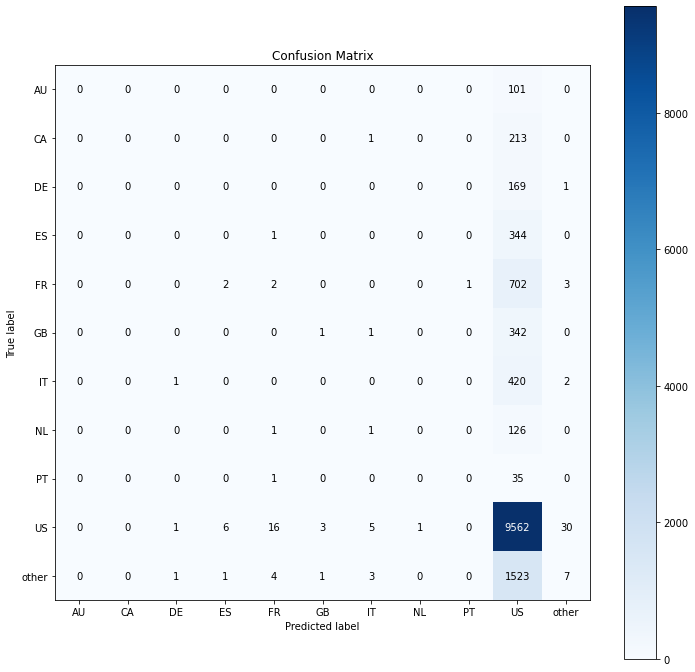

In [79]:
# Accuracy
acc_nn = m.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))


# Balanced Accuray
# F-Score Balanced
# Recall-Precison
# ROC 
# Kappa Metrics
# Matthew Metrics